## Some preliminaries, you will need 

- PyCall --- Pkg.add("Pycall")


In [1]:
# You may need to change this to load from the correct directory.
include("../juliaCode/open-systems.jl")
include("../juliaCode/PTSM.jl")
include("../juliaCode/Initial.jl")
include("../juliaCode/Symplectic.jl")
include("../juliaCode/useful.jl")

# Quick Recap and introduction to makeFromCommands

### So just a reminder, 
- we can setup two qubit state
- Apply gates
- Then we can decompose it (to get the commands needed to build it)
- And *NEW* to this worksheet we can make the matrix version of the state from the commands
- Also (for two qubits) we can relatively easily find out how to make them from arbitrary generators.

In [2]:
# state is used as a global here
# You don't need to use the global - most commands accept a 'state' matrix to act on.
state =  setup(3)

6×7 Array{Int32,2}:
 1  0  0  0  0  0  0
 0  1  0  0  0  0  0
 0  0  1  0  0  0  0
 0  0  0  1  0  0  0
 0  0  0  0  1  0  0
 0  0  0  0  0  1  0

In [3]:
# the ! after cnot is to remind us we are changing a global (here state)
cnot!(1,3,false) # the false supresses output.
cnot!(3,1,false)
cnot!(2,3,false)
phase!(1,false)
output(state)

+IIX
+IXX
+YIX
----
+ZZZ
+IZI
+ZII


In [4]:
# So because the decomposition is 'rote' [Gaussian elimination], it's not necessarily the 'best'
decomposeState(state)

Tableau for unitary: 
+IIX
+IXX
+YIX
----
+ZZZ
+IZI
+ZII
setup(3)
phase(3)
phase(3)
phase(3)
hadamard(3)
hadamard(2)
hadamard(1)
cnot(3,2)
cnot(3,1)
cnot(1,3)
cnot(1,2)
hadamard(3)
hadamard(2)
hadamard(1)
output(state)


In [5]:
c1=round.(makeFromCommand(commands),8)

8×8 Array{Complex{Float64},2}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0-1.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0-1.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0-1.0im

# Using the finite fields software
--- this is the part we need PyCall for

In [6]:
using PyCall

### The next line imports the relevant python packages.

If you don't have them installed then you may need to do something like
    
`using Conda
Conda.add("scipy")
`

In [7]:
@pyimport scipy.optimize as so
@pyimport numpy as np
@pyimport matplotlib.pyplot as plt


## We need to get the Python finite field package working

In [8]:
# You just need to make sure python's path includes the correct directory
unshift!(PyVector(pyimport("sys")["path"]), "../finite-fields/")
@pyimport finitefield as ff

In [9]:
# A 'binary' finite field upto x^2 - this prints out the generator used (can vary)
F22= ff.FiniteField(2,2)

PyObject <class 'finitefield.FiniteField.<locals>.Fq'>

In [10]:
@pyimport SLFunctions as sl

In [11]:
# This calls the getF2Stabilisers, which are the two qubit stabilisers. reshaped appropriately
function getStabilisers()
    jstabs=Array{Int64,2}[]
    stabs = sl.getF2Stabilisers()
    for i in 1:size(stabs,1)
        push!(jstabs,reshape(stabs[i,:,:],4,4))
    end
    return jstabs
end


getStabilisers (generic function with 1 method)

In [12]:
stabs=getStabilisers();
length(stabs)

60

### Although we are only going to go through the 2 qubit stuff in this workbook, if we wanted to do it for 3 qubits its still relatively trivial

- Create the field

`F23= ff.FiniteField(2,3)`

- Then get the stabilisers, here its F3Stabilisers and the state is larger 6x6 not 4x4.

`
function getStabilisers()
    jstabs=Array{Int64,2}[]
    stabs = sl.getF3Stabilisers()
    for i in 1:size(stabs,1)
        push!(jstabs,reshape(stabs[i,:,:],6,6))
    end
    return jstabs
end
`

In [13]:
F23= ff.FiniteField(2,3)
function getStabilisers()
    jstabs=Array{Int64,2}[]
    stabs = sl.getF3Stabilisers()
    for i in 1:size(stabs,1)
        push!(jstabs,reshape(stabs[i,:,:],6,6))
    end
    return jstabs
end
stabs3Q=getStabilisers();
length(stabs3Q)

504

## So we have the F22 stabilisers (60 of them) loaded into "stabs"

---
### If you wanted pre-compiled gates they are already saved. Just FYI.

Since we saved them previously we can load them
`
gates=Array{Float64}[]
for i=1:60
    push!(gates,readdlm("../compiledGates/gateList$i.csv"))
end
`

---

If you haven't already you may need to: Pkg.add("ProgressMeter")
 or just remove the ProgressMeter references, they aren't actually needed.

In [14]:
using ProgressMeter

### So an example of how to make them

In [15]:
#The first one is saved as
stabs[1]

4×4 Array{Int64,2}:
 0  0  1  0
 0  0  0  1
 1  0  0  0
 0  1  0  0

In [16]:
# So setup the blank state and then write this to the state:
state=setup(2)
state[1:4,1:4]=stabs[1]

4×4 Array{Int64,2}:
 0  0  1  0
 0  0  0  1
 1  0  0  0
 0  1  0  0

In [17]:
state

4×5 Array{Int32,2}:
 0  0  1  0  0
 0  0  0  1  0
 1  0  0  0  0
 0  1  0  0  0

In [18]:
# And we can deompose this.
decomposeState(state)

Tableau for unitary: 
+ZI
+IZ
---
+XI
+IX
setup(2)
hadamard(2)
hadamard(1)
output(state)


In [19]:
commands

4-element Array{String,1}:
 "setup(2)"     
 "hadamard(2)"  
 "hadamard(1)"  
 "output(state)"

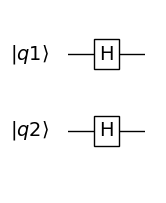

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1541c2d4a8>

In [20]:
include("../juliaCode/plotCircuits.jl")
scheduleIt()

# The process is as follows:
- For each of the 60 stabiliser states 
    - Set them up as a 'state'
    - Decompose them.
    - Then for each of the 16 Paulis we are going to mulitply them by
        - add the commands that generate that Pauli
    - save the commands to make that clifford (i.e. the generator set)
    - Generate the clifford and save the generated clifford
- Save.


We will have 60*16 = 960 cliffords

### Looks good, so lets make them all - doesn't take long with 2 qubits - seconds.

In [21]:
# This is NOT an efficient way of doing this.
# hopefully its clear what is going on
# (For instance we are decomposing each of the 60 states 16 times. We only need to do this once)
# and then return 16 copies of it each with the different paulis. But its only 2 qubits and I thought it was clearer.

sl2Cliffords= Array{Complex{Float64},2}[]
sl2CliffordCommands = Array{String,1}[]
n=60*4*4
for i=1:60
    for j=1:4 # first qubit Pauli
        for z=1:4 # second qubit Pauli
            state=setup(2)
            state[1:4,1:4]=stabs[i]
            decomposeState(state,true)
            #Apply the PAULIS!
            if (j==2) # X
                push!(commands,"hadamard(1)")
                push!(commands,"phase(1)")
                push!(commands,"phase(1)")
                push!(commands,"hadamard(1)")
            elseif (j==3) # Z
                push!(commands,"phase(1)")
                push!(commands,"phase(1)")
            elseif (j==4) # Y
                push!(commands,"phase(1)")
                push!(commands,"phase(1)")
                push!(commands,"hadamard(1)")
                push!(commands,"phase(1)")
                push!(commands,"phase(1)")
                push!(commands,"hadamard(1)")
            end
            if (z==2) # X
                push!(commands,"hadamard(2)")
                push!(commands,"phase(2)")
                push!(commands,"phase(2)")
                push!(commands,"hadamard(2)")
            elseif (z==3) # Z
                push!(commands,"phase(2)")
                push!(commands,"phase(2)")
            elseif (z==4) # Y
                push!(commands,"phase(2)")
                push!(commands,"phase(2)")
                push!(commands,"hadamard(2)")
                push!(commands,"phase(2)")
                push!(commands,"phase(2)")
                push!(commands,"hadamard(2)")
            end
            push!(sl2CliffordCommands,commands)
            push!(sl2Cliffords,makeFromCommand(commands))
        end
    end
end

In [22]:
# Sanity check size is 60*16
size(sl2Cliffords)

(960,)

In [23]:
sl2CliffordCommands[1]

4-element Array{String,1}:
 "setup(2)"     
 "hadamard(2)"  
 "hadamard(1)"  
 "output(state)"

# So the number of gates is the length of the commands minus 2

In [24]:
sl2CliffordsLength = [size(sl2CliffordCommands[i],1)-2 for i=1:size(sl2CliffordCommands,1)]
print("Size is $(size(sl2CliffordsLength,1)) and mean is $(mean(sl2CliffordsLength))")

Size is 960 and mean is 17.2

## Check if it is unitary 2 - uses formula (9) of Gross et al - Evenly distributed unitaries: On the structure of unitary designs

In [25]:
# If it is a unitary-2 design the frame potential will be 2
sumSoFar = 0
numb = size(sl2Cliffords,1)
p = Progress(numb*numb,1)
for i=1:numb
    for j=1:numb
        sumSoFar += abs(trace(conj(sl2Cliffords[i])'*sl2Cliffords[j]))^4
        next!(p)
    end
end
frame = round(sumSoFar/numb^2,8)
print("Frame potential is -> $frame\n")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01

Frame potential is -> 2.0


## And the magic number is indeed 2

(note: useful.jl has this just: checkFrame(sl2Cliffords))

## Now lets compare with the actual full Clifford Group.

In [26]:
getNumberOfCliffords(2)

11520

In [27]:
getNumberOfSymplecticCliffords(2) # this is the number mapped to integers

720

In [28]:
getNumberOfBitStringsCliffords(2) # this is the number we multiply it by

16

In [29]:
720*16

11520

In [30]:
FullCliffords= Array{Complex{Float64},2}[]
FullCliffordCommands = Array{String,1}[]
n=11520
p=Progress(n,1)
for i=1:720 # number of symplectics
    for j=1:16 # number of phase variations.
        state=setup(2)
        decompose(i,j,2,true,true) # symplectic i, bits j, 2 qubits, no output and rationalise
        push!(FullCliffordCommands,commands)
        push!(FullCliffords,makeFromCommand(commands))
        next!(p)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [31]:
size(FullCliffords)

(11520,)

In [32]:
FullCliffords[1]

4×4 Array{Complex{Float64},2}:
  0.707107+0.0im        0.0+0.0im  0.707107+0.0im       0.0+0.0im
       0.0+0.0im   0.707107+0.0im       0.0+0.0im  0.707107+0.0im
 -0.707107+0.0im        0.0+0.0im  0.707107+0.0im       0.0+0.0im
       0.0+0.0im  -0.707107+0.0im       0.0+0.0im  0.707107+0.0im

## Check we have done it correctly (unitary 2)

In [33]:
# Might take a minute or so
frame = round(checkFrame(FullCliffords))
print("Frame potential -> $frame\n")

Frame potential -> 2.0


In [34]:
FullCliffordsLength = [size(FullCliffordCommands[i],1)-2 for i=1:size(FullCliffordCommands,1)]
print("Size is $(size(FullCliffordsLength,1)) and mean is $(mean(FullCliffordsLength))")

Size is 11520 and mean is 12.42986111111111

## We could 'bruce force' optimise every single gate (see below code) but there is a better way


# This is going to take a very long time on 3 qubits

```
function bruteForceBreadthFirst(clifford)
	global svec
	count = 0
	n=div(size(clifford,1),2) # half the dimension of this 2n x (2n+1) matrix
	if (n > 4) 
		println("This might take some time!, there are ",n*(n+1) + n + n, " different gates , we might need ", n*n/log(n), " of them so I *might* have to check ", n*n/log(n)^(n*(n+1) + n + n), "combos !")
		println("Ctrl-C could be your friend")
	end
	gates = (Expr)[]
	svec = []
	# If we have a n quibit system then there are a total of 
	# n*(n+1) possible cnots, n phase gates and n hadamards we can apply
	for i = 1:n
	  for j = 1:n
	  	if i!=j
	  		push!(gates,Expr(:call,:cnot,:svec,i,j,false))
	  	end
	  end
	  push!(gates,Expr(:call,:hadamard,:svec,i,false))
	  push!(gates,Expr(:call,:phase,:svec,i,false))
	end
	# so we now have an array of all possible gates we can apply to the system
	# we want to search through the gates, we "should" need at most n^2 of them.
	# The process will be to have a stack of gates to apply, check them out
	# if we match getState(11) i.e. they reverted the clifford to the initial state
	# we have found the gates needed
	# otherwise we increment our "bottom" gate, and if we have gone though them, recursively increment the 
	# gate above it (incrementGate! does this for us)
	state = 0
	maxGates = size(gates,1);
	gatesToApply=(Int32)[]
	if getState(clifford) == 11
		println("Very funny you don't need to do anything")
		return [Expr(:noop)]
	end
	currentAt = 1
	while (state!=11 && size(gatesToApply,1) < n*n*n*n*n*n*n*n*n*n)
		svec = copy(clifford)
		incrementGate!(gatesToApply,maxGates)
		count += 1
		if (size(gatesToApply,1) > currentAt)
			#print("Trying: ")
			#	for i=1:size(gatesToApply,1)
			#	print(gatesToApply[i]," ")
			#end
			#println("")
			currentAt+=1
		end
		for index=1:size(gatesToApply,1)
			#println("Going to apply ",gates[gatesToApply[index]])
			eval(gates[gatesToApply[index]])
		end
		state = getState(svec)
	end

	if (state == 11)
		#println("Found it after (only) $count permuations")
		#println("Gates applied")
		reverse!(gatesToApply)
		#for i = 1:size(gatesToApply,1)
			#println(gates[gatesToApply[i]])
		#end
	else
		println("Didn't find it!")
	end
	return gatesToApply
end
```

## A better way to do this, is to realise the sl2 cliffords are a subset of the full cliffords.

### We can (more efficiently) work the minimum generators required for each clifford and then just read them off for our 'reduced' group.

- So set up our generator group
- Set our gates generated to the generator group
- Repeat
    - for each generator
      - for each gate generated so far
        - multiply the generator (LHS) with the gate (RHS). Is it something we haven't got 
            - if yes add it to the gates generated so far
            - keep a note of which generators were used (being the new one (LHS) and the ones used for the RHS gate)
    - Did we add any gates that pass through - if not we are done.
    
Note this algorithm requires that we check to see if we have already generated a gate, but prima facie this might seem tricky as we could have gates that are identical apart from an overall global phase. IMO the easiest way to do this is to through them up into the Pauli Liouville SuperOperator basis, which is actually a projective representation (bye bye global phase). I'm sure there is a workbook somewhere explaining this so I'll just point out what we are going to use:

`makeSuper(x)`

which takes one of our matrices (4x4) and puts in in the PL SuperOperator basis (16x16)

`findfirst(haystack,needle)` 

which returns the position of needle in haystack (or 0 if not found) and works even if the needle is an array and haystack is an array (vector) of arrays.

In [35]:
# convert our cliffords to Super cliffords! (note this takes a surprising amount of time - couple of mins)
SuperCliffs = [makeSuper(i) for i in FullCliffords];

## So what are our generators?

Obviously here you can insert whatever your actual generators are! For this worksheet I will stick with the phase, hadamard and cnot generators. 

In [36]:
singleBitPhase = [1 0;0 im]
singleBitHadamard = 1/sqrt(2)*[1 1;1 -1]
singleBitIdentity = [1 0;0 1]
singleBitX = [0 1;1 0]

gPI = kron(singleBitPhase,singleBitIdentity)
gIP = kron(singleBitIdentity,singleBitPhase)
gHI = kron(singleBitHadamard,singleBitIdentity)
gIH = kron(singleBitIdentity,singleBitHadamard)
cnot12 = kron([1;0]*[1 0],singleBitIdentity) + kron([0;1]*[0 1],singleBitX)
cnot21 = kron(singleBitIdentity,[1;0]*[1 0]) +kron(singleBitX,[0;1]*[0 1])

4×4 Array{Int64,2}:
 1  0  0  0
 0  0  0  1
 0  0  1  0
 0  1  0  0

In [37]:
base2QGens = [gPI,gIP,gHI,gIH,cnot12,cnot21]
superGens2Q = [makeSuper(i) for i in base2QGens];
humanReadable = ["P \\otimes I","I \\otimes P","H \\otimes I","I \\otimes H","CNOT_{12}","CNOT_{21}"]
machineReadable=["phase(1)","phase(2)","hadamard(1)","hadamard(2)","cnot(1,2)","cnot(2,1)"]

6-element Array{String,1}:
 "phase(1)"   
 "phase(2)"   
 "hadamard(1)"
 "hadamard(2)"
 "cnot(1,2)"  
 "cnot(2,1)"  

## Then we just do the algorithm below

For only 2 qubits this doesn't take long at all.


In [38]:
minPaths2Q=[]

# Clear the paths one for each clifford
for i=1:length(SuperCliffs)
    push!(minPaths2Q,[])
end


# Set up the generators in the paths.
for i=1:length(superGens2Q)
    t1=findfirst(SuperCliffs,superGens2Q[i])
    minPaths2Q[t1]=[i]
end

# Keeps track of if we have any new gates.
doneOne = true

p=Progress(count([x==[] for x in minPaths2Q]),1)
todo = count([x==[] for x in minPaths2Q])
havedone=0
newPaths2Q=copy(minPaths2Q)
while doneOne && (havedone < todo) # hasempty(minPaths)
    doneOne = false
    for i in 1:length(superGens2Q)
        for j in 1:length(minPaths2Q) 
              if minPaths2Q[j]!=[]
                  t1 = findfirst(SuperCliffs,superGens2Q[i]*SuperCliffs[j])
                  if newPaths2Q[t1]==[]

                      #print("Gave $t1, which has not been found\n")
                      #print("Minpaths $([xgenerators[i]]) and $(minPaths[j])\n")
                      #print("And then $(hcat([xgenerators[i]],copy(minPaths[j])))")
                      
                      newPaths2Q[t1] = hcat([i],copy(minPaths2Q[j]))
                      doneOne = true
                      next!(p)
                      havedone = havedone+1
                      if havedone >= todo
                        print("Done enough\n")
                        break;
                      end
                  end
             end
        end
    end
    minPaths2Q=copy(newPaths2Q)
    print("That pass we now have $(count([x==[] for x in minPaths2Q])) Cliffords left, $(length(SuperCliffs)-count([x==[] for x in minPaths2Q])) done, max length $(maximum([length(i) for i in minPaths2Q])).\n")
end
print("Done, mean gatelength is $(mean([length(i) for i in minPaths2Q]))\n")

That pass we now have 11487 Cliffords left, 33 done, max length 2.
That pass we now have 11391 Cliffords left, 129 done, max length 3.


Progress:   3%|█                                        |  ETA: 0:00:29

That pass we now have 11099 Cliffords left, 421 done, max length 4.


Progress:  10%|████                                     |  ETA: 0:00:19

That pass we now have 10365 Cliffords left, 1155 done, max length 5.
That pass we now have 8871 Cliffords left, 2649 done, max length 6.


Progress:  44%|██████████████████                       |  ETA: 0:00:14

That pass we now have 6423 Cliffords left, 5097 done, max length 7.


Progress:  70%|█████████████████████████████            |  ETA: 0:00:10

That pass we now have 3388 Cliffords left, 8132 done, max length 8.


Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:04

That pass we now have 964 Cliffords left, 10556 done, max length 9.


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

That pass we now have 52 Cliffords left, 11468 done, max length 10.


Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

Done enough
That pass we now have 0 Cliffords left, 11520 done, max length 11.
Done, mean gatelength is 7.558506944444445


Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


## So now we have all the generators we need for all the cliffords

In [43]:
# e.g.
minPaths2Q[34]

1×6 Array{Int64,2}:
 2  2  3  6  5  4

In [40]:
# Where the generators are mapped as done previously
[humanReadable[i] for i in minPaths2Q[34]]

1×6 Array{String,2}:
 "I \\otimes P"  "I \\otimes P"  …  "CNOT_{12}"  "I \\otimes H"

In [41]:
# And if we want to read off the '60' sl2 Cliffords
superSL2Cliffords = [makeSuper(i) for i in sl2Cliffords];

### Note, because we haven't set the identity it has had to be created from two generators should probably override.

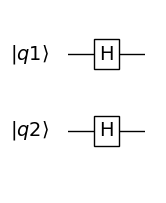

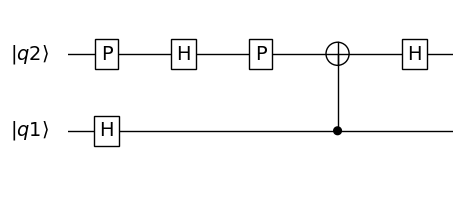

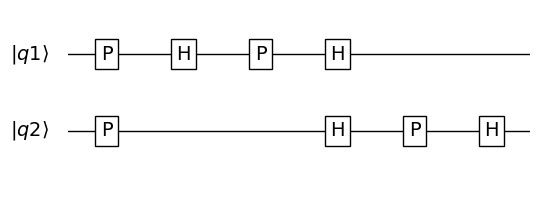

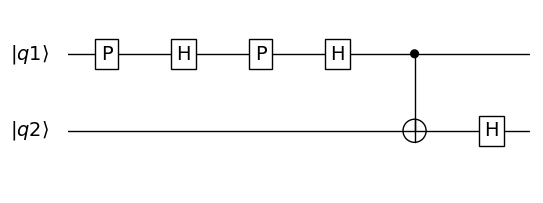

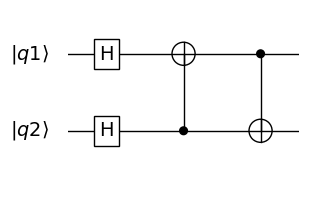

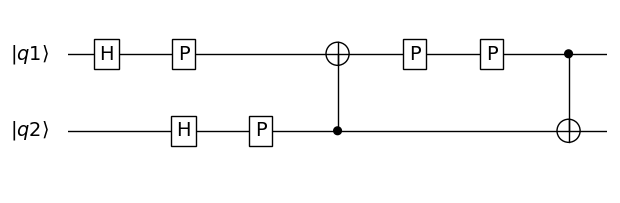

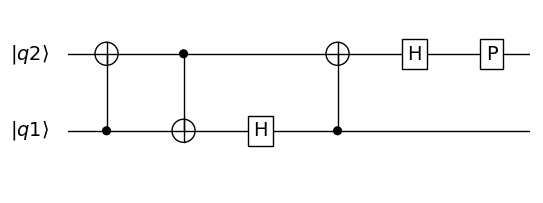

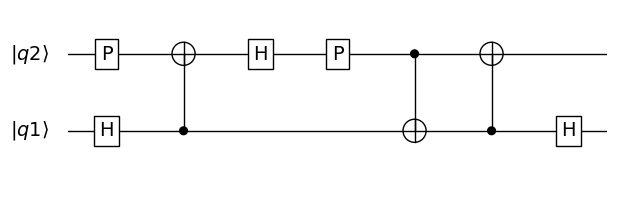

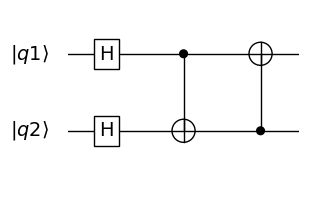

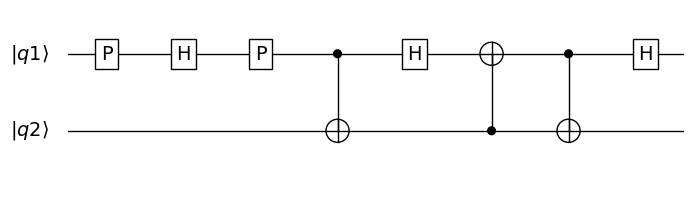

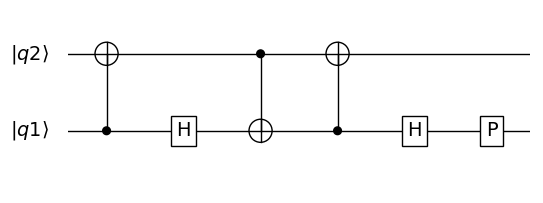

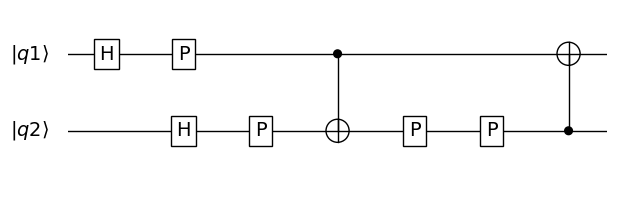

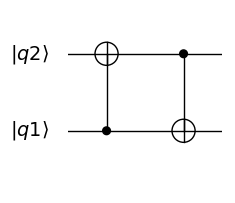

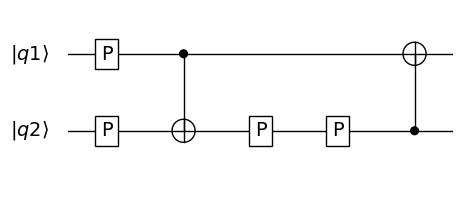

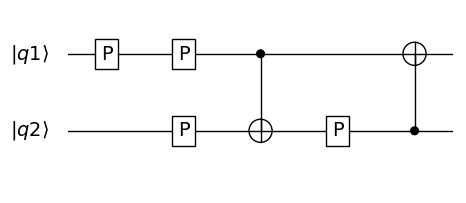

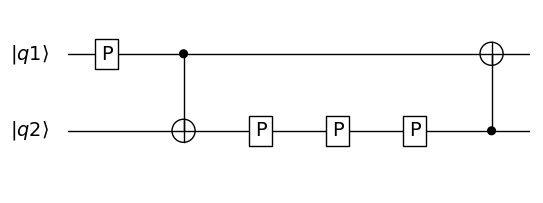

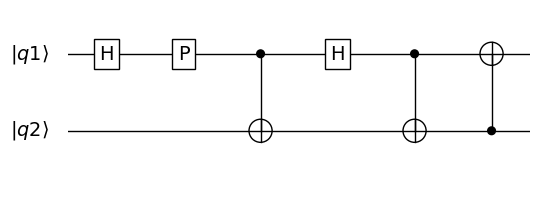

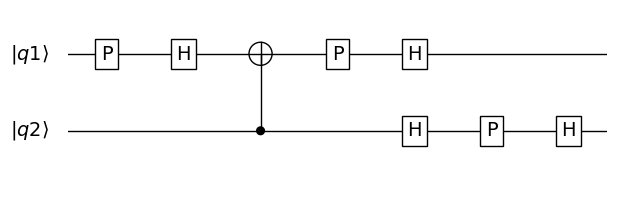

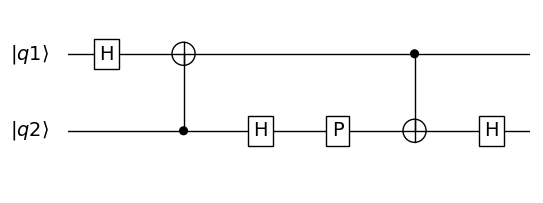

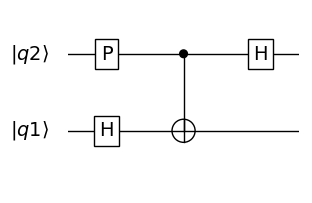

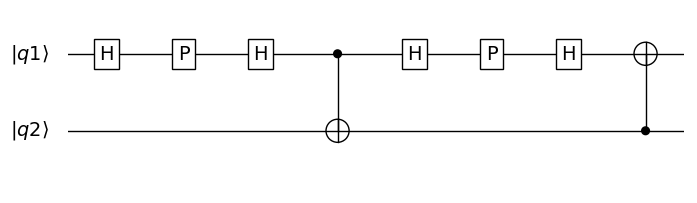

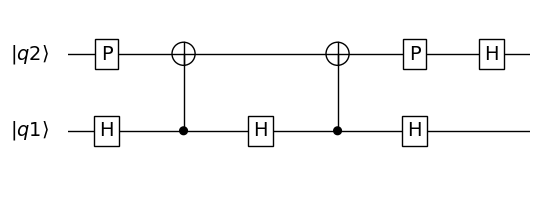

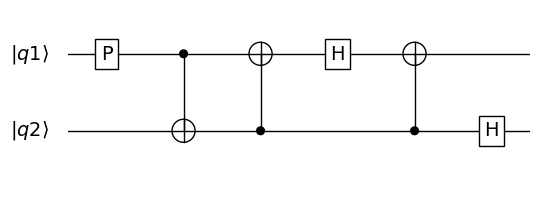

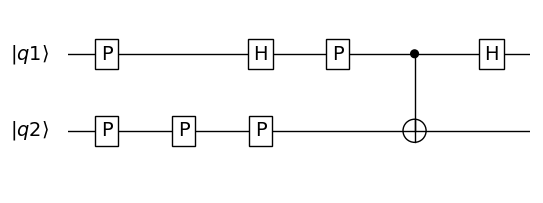

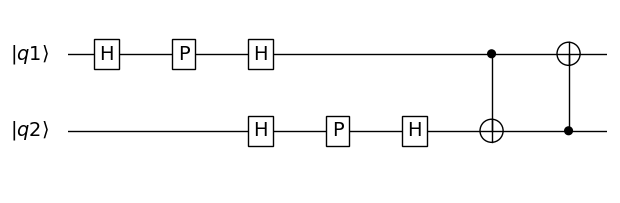

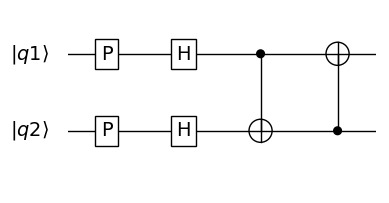

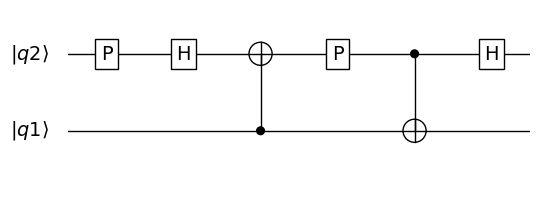

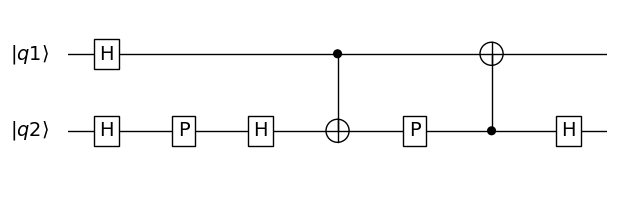

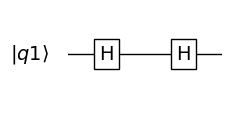

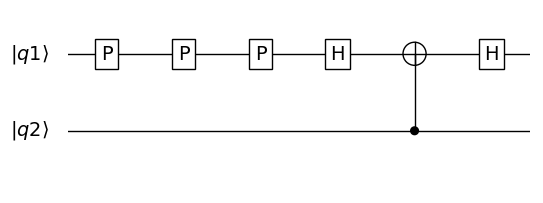

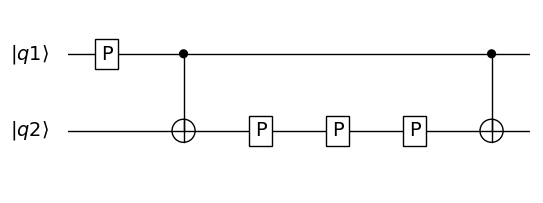

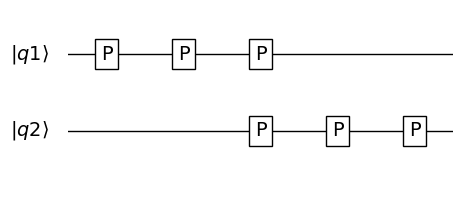

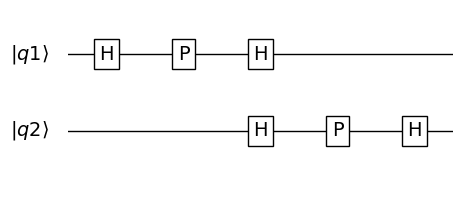

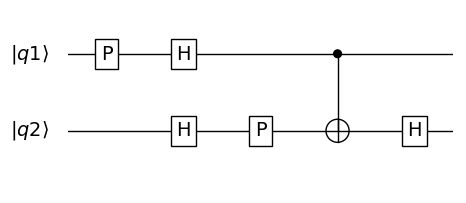

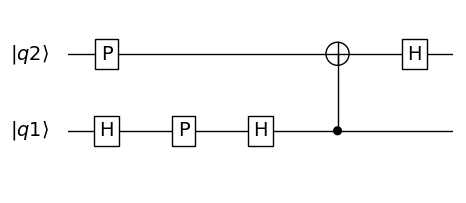

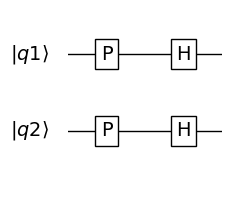

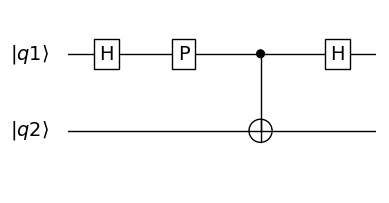

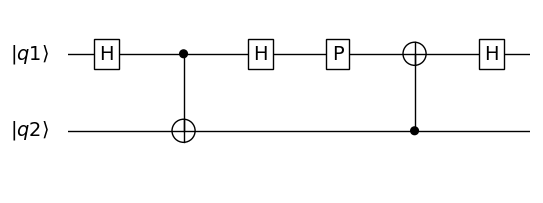

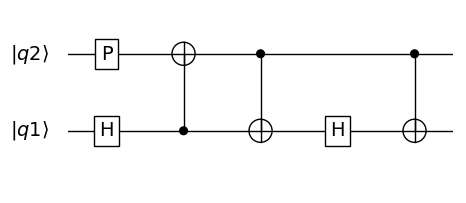

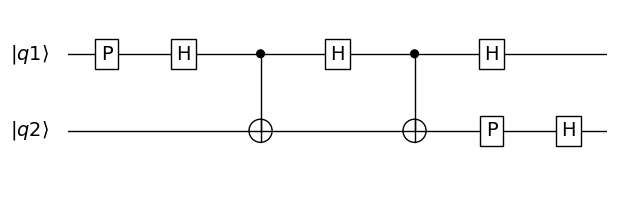

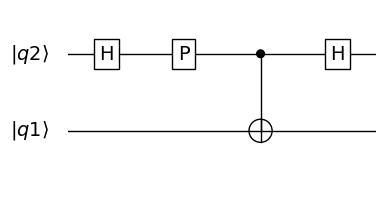

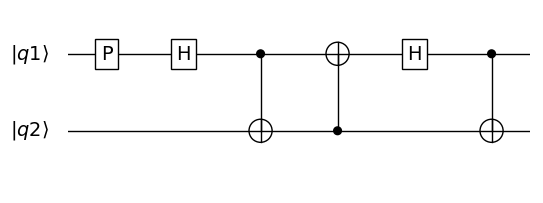

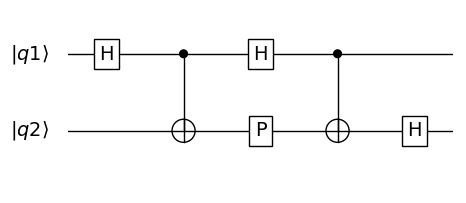

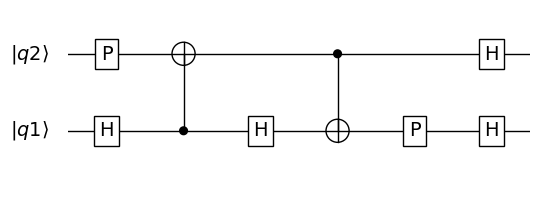

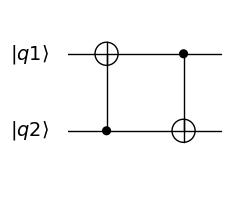

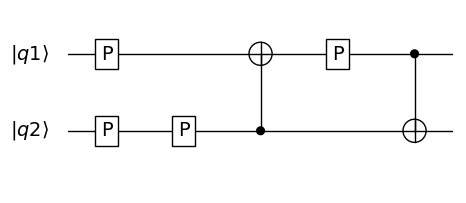

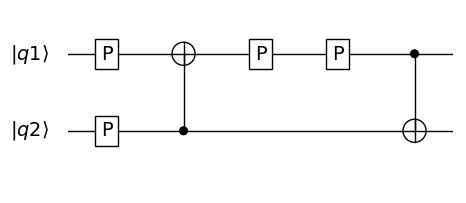

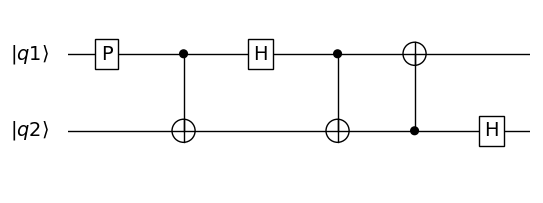

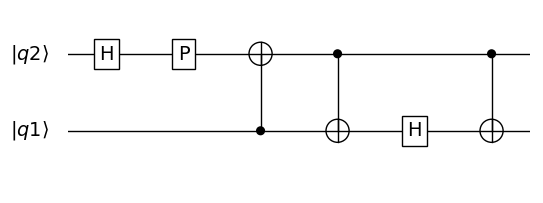

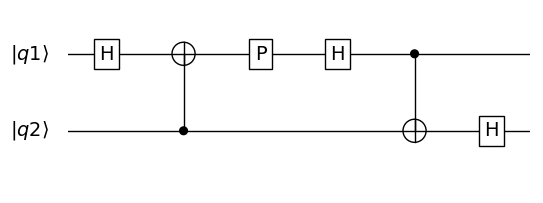

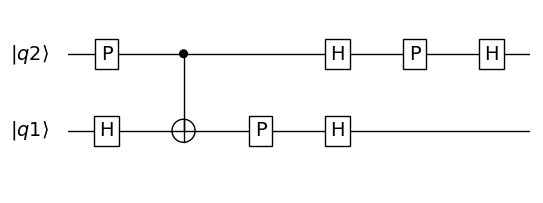

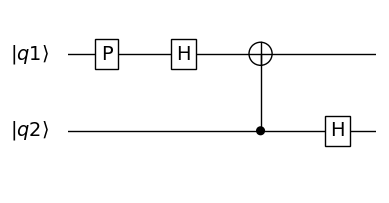

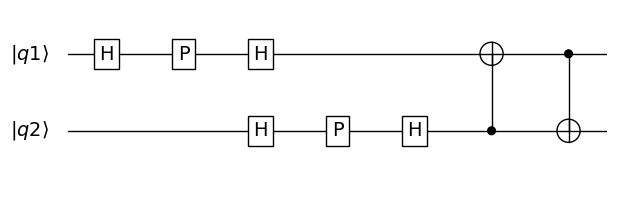

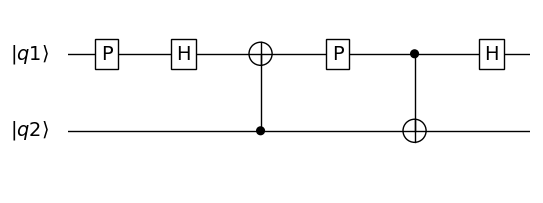

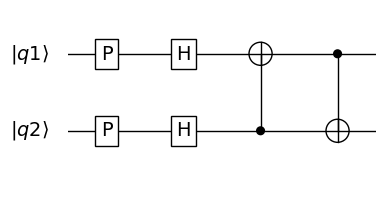

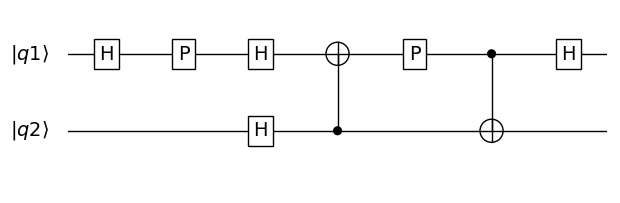

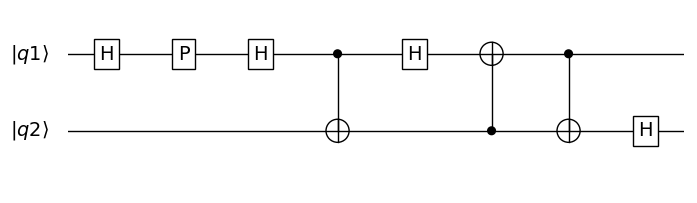

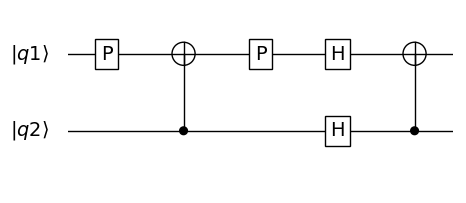

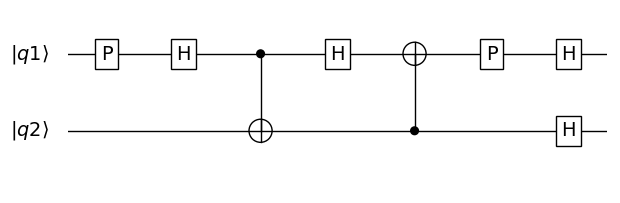

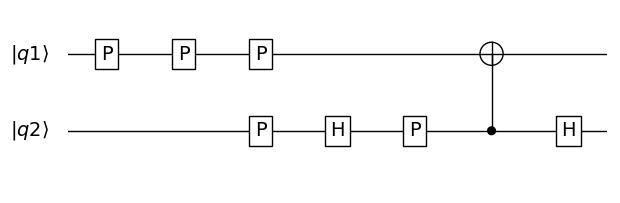

In [42]:
for i in [findfirst(SuperCliffs,sl) for sl in (superSL2Cliffords[1:16:960])]
    commands = vec([machineReadable[j] for j in minPaths2Q[i]])
    scheduleIt()
end